In [1]:
!pip install numpy==1.24.4 scipy==1.11.4 gensim==4.3.1

# **Pengenalan**

- Nama : Nurnia Hamid
- Email : a309xaf385@devacademy.id
- Submission 1 : Belajar Pengemmbangan Machine Learning

- Proyek : Analisis Sentimen Review Aplikasi Tokopedia Seller

- Sumber data : Scraping review di google play store aplikasi 'Tokepedia Seller'

- link : https://play.google.com/store/search?q=tokopedia%20seller&c=apps&hl=id

# **Import Library**

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.svm import SVC
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer

# **Load Data**


Data telah di scraping dan diupload ke GitHub

In [3]:
url = "https://raw.githubusercontent.com/nurniahamid/tokopediaseller/refs/heads/main/review_tokopedia_seller.csv"
df = pd.read_csv(url)
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,d49873d1-491b-49da-9e5b-6159c4e5619d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"yang paling membuat malas sama tokopedia, bant...",1,0,2.240.0,2025-05-09 11:00:32,NaN,NaN,2.240.0
1,dd90bc6f-00e3-4554-b4a2-56030978e502,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Tokopedia seller sekarang sudah jadi budak nya...,1,4,2.161,2025-05-09 10:29:56,Terima kasih atas penilaian yang kamu berikan....,2025-04-29 11:40:05,2.161
2,528a0bf7-4dcc-47bf-8794-5ce33c8a1a92,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,kenapa saya tidak bisa mengirimkan gambar/foto...,3,0,2.176,2025-05-09 08:15:24,NaN,NaN,2.176
3,b4106033-16e4-48be-94ee-75bfaf43753d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,mantap,5,0,2.240.0,2025-05-09 06:43:36,NaN,NaN,2.240.0
4,ecee3f82-9cc8-49f7-9c3e-29c026f875ff,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,kecewa banget kenapa di gabung tiktokseller,1,1,2.161,2025-05-09 06:37:31,NaN,NaN,2.161


Kita menghilangkan beberapa kolom dan hanya menyisakan kolom yang akan digunakan dalam analisis sentimen yaitu 'userName', 'content', 'score'

In [4]:
df = df[['userName', 'content', 'score']]
df.head()

,userName,content,score
0,Pengguna Google,"yang paling membuat malas sama tokopedia, bant...",1
1,Pengguna Google,Tokopedia seller sekarang sudah jadi budak nya...,1
2,Pengguna Google,kenapa saya tidak bisa mengirimkan gambar/foto...,3
3,Pengguna Google,mantap,5
4,Pengguna Google,kecewa banget kenapa di gabung tiktokseller,1


# **EDA & Text_Preprocessing**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  11000 non-null  object
 1   content   11000 non-null  object
 2   score     11000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 257.9+ KB


Dataset yang akan kita gunakan berjumlah 11000

In [6]:
df.isnull().sum()

,0
userName,0
content,0
score,0


dari hasil yang didapatkan, tidak terdapat lagi nilai null dalam data

Selanjutnya kita masuk ketext Pre-Processing data

- Case Folding bersungsi untuk mengubah huruf besar menjadi huruf kecil dengan menggunakan fungsi lower()
- case folding berfungsi untuk membersihkan data, dalam proeyek ini kita melakukan cleansing dengan menghapus url, menghapus mention, tanda baca, angka, karakter newline, karakter non-ASCII dan menghapus spasi awal dan spasi akhir yang ada di teks

In [7]:
# case folding

def case_folding(content):
  if isinstance(content,str):
    content = content.lower()
  return content
df['case_folding'] = df['content'].apply(case_folding)

# cleansing
import string
def cleansing(content):
    if isinstance(content, str):
        content = re.sub(r"http\S+", "", content)
        content = re.sub(r"@[A-Za-z0-9_]+", "", content)
        content = content.translate(str.maketrans("", "", string.punctuation))
        content = re.sub(r'\d+', '', content)
        content = content.replace('\n', ' ')
        content = re.sub(r'[^\x00-\x7f]', r'', content)
        content = content.strip(' ')
    return content
df['cleansing'] = df['case_folding'].apply(cleansing)
df.head()


<ipython-input-7-a9bd3f5a2f5c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['case_folding'] = df['content'].apply(case_folding)


,userName,content,score,case_folding,cleansing
0,Pengguna Google,"yang paling membuat malas sama tokopedia, bant...",1,"yang paling membuat malas sama tokopedia, bant...",yang paling membuat malas sama tokopedia bantu...
1,Pengguna Google,Tokopedia seller sekarang sudah jadi budak nya...,1,tokopedia seller sekarang sudah jadi budak nya...,tokopedia seller sekarang sudah jadi budak nya...
2,Pengguna Google,kenapa saya tidak bisa mengirimkan gambar/foto...,3,kenapa saya tidak bisa mengirimkan gambar/foto...,kenapa saya tidak bisa mengirimkan gambarfoto ...
3,Pengguna Google,mantap,5,mantap,mantap
4,Pengguna Google,kecewa banget kenapa di gabung tiktokseller,1,kecewa banget kenapa di gabung tiktokseller,kecewa banget kenapa di gabung tiktokseller


Selanjutnya proses tokenisasi
- tokenisasi berfungsi memecah teks atau kalimat menjadi kata per kata atau yang disebut token, Pada proyek ini kita menggunakan nltk dalam proses tokenisasi

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#tokenisasi
nltk.download('punkt_tab')
df['tokenized'] = df['cleansing'].apply(word_tokenize)
df.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,userName,content,score,case_folding,cleansing,tokenized
0,Pengguna Google,"yang paling membuat malas sama tokopedia, bant...",1,"yang paling membuat malas sama tokopedia, bant...",yang paling membuat malas sama tokopedia bantu...,"[yang, paling, membuat, malas, sama, tokopedia..."
1,Pengguna Google,Tokopedia seller sekarang sudah jadi budak nya...,1,tokopedia seller sekarang sudah jadi budak nya...,tokopedia seller sekarang sudah jadi budak nya...,"[tokopedia, seller, sekarang, sudah, jadi, bud..."
2,Pengguna Google,kenapa saya tidak bisa mengirimkan gambar/foto...,3,kenapa saya tidak bisa mengirimkan gambar/foto...,kenapa saya tidak bisa mengirimkan gambarfoto ...,"[kenapa, saya, tidak, bisa, mengirimkan, gamba..."
3,Pengguna Google,mantap,5,mantap,mantap,[mantap]
4,Pengguna Google,kecewa banget kenapa di gabung tiktokseller,1,kecewa banget kenapa di gabung tiktokseller,kecewa banget kenapa di gabung tiktokseller,"[kecewa, banget, kenapa, di, gabung, tiktoksel..."


selanjutnya tahapan normalisasi
- normaliasi berfungsi untuk mengubah kata-kata tidak baku menjadi bentuk baku/standard, agar analisis teks kita di proyek ini menjadi lebih akurat dan konsisten

In [9]:
#normalisasi
kamus_normalisasi = {
    "gak": "tidak",
    "ga": "tidak",
    "nggak": "tidak",
    "gk": "tidak",
    "yg": "yang",
    "aja": "saja",
    "udah": "sudah",
    "tokped": "tokopedia",
    "bgt": "banget",
    "trs": "terus",
    "tp": "tapi",
    "dr": "dari",
    "dgn": "dengan",
    "klo": "kalau",
    "blm": "belum",
    "sdh": "sudah",
    "sm": "sama",
    "nya": "",
    "nyaa": "",
    "bikin": "membuat",
    "aja": "saja",
    "kalo": "kalau",
    "tdk": "tidak",
    "bgtu": "begitu",
    "bantuam": "bantuan",
    "jd": "jadi",
    "mantab": "mantap",
    "banget": "sangat",
}
def normalisasi_kata(tokens, kamus):
    return [kamus.get(word.lower(), word.lower()) for word in tokens]
df['normalized'] = df['tokenized'].apply(lambda tokens: normalisasi_kata(tokens, kamus_normalisasi))


selanjutnya stopwords
- stopword ini adalah kata-kata umum yang sering muncul dalam teks, tetapi bisanya tidak membawa makna penting untuk proses analisis, sama seperti tokenisasi kita juga menggunakan nltk yaitu modul stopwords

In [21]:
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

df['stopwords'] = df['normalized'].apply(lambda tokens: [word for word in tokens if word not in stop_words and word.isalpha()])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


menggabungkan kembali daftar kata (token) yang sebelumnya telah difilter dari stopword, menjadi teks utuh dalam bentuk string

In [11]:
df['stopwords_text'] = df['stopwords'].apply(lambda tokens: ' '.join(tokens))

Instal Sastrawi untuk diguanakn dalam proses stemming

In [12]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.7 MB/s eta 0:00:00


- Stemming ini berfungsi mengubah kata ke bentuk dasarnya, untuk membantu model fokus pada makna inti kata, disini kita menggunakan library Sastrawi untuk stemming bahasa indonesia

In [13]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tqdm import tqdm
tqdm.pandas()

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming_per_token(token_list):
    return [stemmer.stem(token) for token in token_list]

df['stemming'] = df['stopwords_text'].progress_apply(lambda text: stemmer.stem(text))


100%|██████████| 11000/11000 [13:07<00:00, 13.97it/s]


In [14]:
df.head()

,userName,content,score,case_folding,cleansing,tokenized,normalized,stopwords,stopwords_text,stemming
0,Pengguna Google,"yang paling membuat malas sama tokopedia, bant...",1,"yang paling membuat malas sama tokopedia, bant...",yang paling membuat malas sama tokopedia bantu...,"[yang, paling, membuat, malas, sama, tokopedia...","[yang, paling, membuat, malas, sama, tokopedia...","[malas, tokopedia, bantuan, chat, reply, tolon...",malas tokopedia bantuan chat reply tolong terk...,malas tokopedia bantu chat reply tolong kait s...
1,Pengguna Google,Tokopedia seller sekarang sudah jadi budak nya...,1,tokopedia seller sekarang sudah jadi budak nya...,tokopedia seller sekarang sudah jadi budak nya...,"[tokopedia, seller, sekarang, sudah, jadi, bud...","[tokopedia, seller, sekarang, sudah, jadi, bud...","[tokopedia, seller, budak, tiktokshop, tolol, ...",tokopedia seller budak tiktokshop tolol tokope...,tokopedia seller budak tiktokshop tolol tokope...
2,Pengguna Google,kenapa saya tidak bisa mengirimkan gambar/foto...,3,kenapa saya tidak bisa mengirimkan gambar/foto...,kenapa saya tidak bisa mengirimkan gambarfoto ...,"[kenapa, saya, tidak, bisa, mengirimkan, gamba...","[kenapa, saya, tidak, bisa, mengirimkan, gamba...","[mengirimkan, gambarfoto, custamermau, lihat, ...",mengirimkan gambarfoto custamermau lihat ulasa...,kirim gambarfoto custamermau lihat ulas tulis ...
3,Pengguna Google,mantap,5,mantap,mantap,[mantap],[mantap],[mantap],mantap,mantap
4,Pengguna Google,kecewa banget kenapa di gabung tiktokseller,1,kecewa banget kenapa di gabung tiktokseller,kecewa banget kenapa di gabung tiktokseller,"[kecewa, banget, kenapa, di, gabung, tiktoksel...","[kecewa, sangat, kenapa, di, gabung, tiktoksel...","[kecewa, gabung, tiktokseller]",kecewa gabung tiktokseller,kecewa gabung tiktokseller


# **Pelabelan**

Pelabelan ini adalah tahapan untuk kita memberikan target/label kelas pada teks, agar bisa diklasifikasi sentimen (positif, negatif, dan netral)

Karena kita melakukan pelabelan menggunakan Text Blob, yang mana hanya bisa untuk data berbahasa inggris, jadi kita perlu menterjemahkan data terlebih dahulu kedalam bahasa inggris. Disini kita menggunakan deep translator

In [15]:
!pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.8 MB/s eta 0:00:00


In [16]:
from deep_translator import GoogleTranslator
from tqdm import tqdm

def translate_text(tokens):
    try:
        if isinstance(tokens, list):
            text = ' '.join(tokens)
        else:
            text = tokens
        return GoogleTranslator(source='auto', target='en').translate(text)
    except Exception as e:
        return f"Error: {e}"

tqdm.pandas()
df['translated'] = df['stemming'].progress_apply(translate_text)
df[['stemming', 'translated']].head()


100%|██████████| 11000/11000 [20:19<00:00,  9.02it/s]


,stemming,translated
0,malas tokopedia bantu chat reply tolong kait s...,Lazy Tokopedia Help chat Reply please hook the...
1,tokopedia seller budak tiktokshop tolol tokope...,Tokopedia Seller Slave Tiktokshop Stupid Tokop...
2,kirim gambarfoto custamermau lihat ulas tulis ...,Send CustamerMau Photo Photo See Donlod and Do...
3,mantap,stable
4,kecewa gabung tiktokseller,Disappointed Join Tiktokseller


setelah ditranslate, selanjutnya kita lakukan pelabelan pada teks menggunakan text blob

In [17]:
from textblob import TextBlob

def get_polarity(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

def get_subjectivity(text):
    try:
        return TextBlob(text).sentiment.subjectivity
    except:
        return None

def get_sentiment_label(polarity):
    try:
        if polarity > 0:
            return 'positif'
        elif polarity < 0:
            return 'negatif'
        else:
            return 'netral'
    except:
        return 'error'

df['polarity'] = df['translated'].apply(get_polarity)
df['subjektivitas'] = df['translated'].apply(get_subjectivity)
df['sentimen'] = df['polarity'].apply(get_sentiment_label)
df[['translated', 'polarity', 'subjektivitas', 'sentimen']].head()

,translated,polarity,subjektivitas,sentimen
0,Lazy Tokopedia Help chat Reply please hook the...,0.350000,0.566667,positif
1,Tokopedia Seller Slave Tiktokshop Stupid Tokop...,-0.800000,1.000000,negatif
2,Send CustamerMau Photo Photo See Donlod and Do...,-0.408333,0.300000,negatif
3,stable,0.000000,0.000000,netral
4,Disappointed Join Tiktokseller,-0.750000,0.750000,negatif


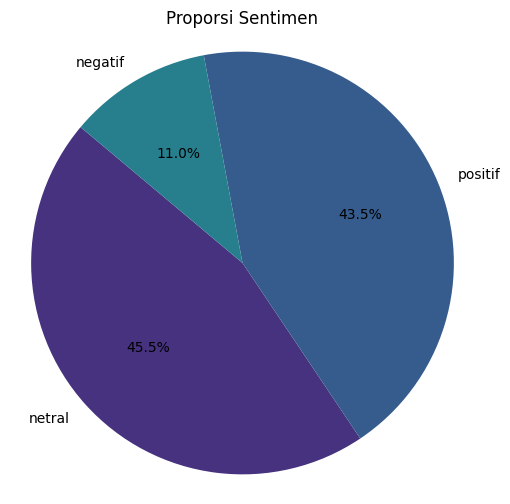

In [18]:
sentiment_counts = df['sentimen'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'))
plt.title('Proporsi Sentimen')
plt.axis('equal')
plt.show()

In [23]:
sentiment_counts = df['sentimen'].value_counts()
print(sentiment_counts)

sentimen
netral     5007
positif    4788
negatif    1205
Name: count, dtype: int64


Dari hasil yang didapatkan jumlahnya sentimen netral paling banyak ditemukan, setelahnya sentimen positif, dan sentimen negatif hanya sedikit atau hanya 11% dari data


In [19]:
df.head()

,userName,content,score,case_folding,cleansing,tokenized,normalized,stopwords,stopwords_text,stemming,translated,polarity,subjektivitas,sentimen
0,Pengguna Google,"yang paling membuat malas sama tokopedia, bant...",1,"yang paling membuat malas sama tokopedia, bant...",yang paling membuat malas sama tokopedia bantu...,"[yang, paling, membuat, malas, sama, tokopedia...","[yang, paling, membuat, malas, sama, tokopedia...","[malas, tokopedia, bantuan, chat, reply, tolon...",malas tokopedia bantuan chat reply tolong terk...,malas tokopedia bantu chat reply tolong kait s...,Lazy Tokopedia Help chat Reply please hook the...,0.350000,0.566667,positif
1,Pengguna Google,Tokopedia seller sekarang sudah jadi budak nya...,1,tokopedia seller sekarang sudah jadi budak nya...,tokopedia seller sekarang sudah jadi budak nya...,"[tokopedia, seller, sekarang, sudah, jadi, bud...","[tokopedia, seller, sekarang, sudah, jadi, bud...","[tokopedia, seller, budak, tiktokshop, tolol, ...",tokopedia seller budak tiktokshop tolol tokope...,tokopedia seller budak tiktokshop tolol tokope...,Tokopedia Seller Slave Tiktokshop Stupid Tokop...,-0.800000,1.000000,negatif
2,Pengguna Google,kenapa saya tidak bisa mengirimkan gambar/foto...,3,kenapa saya tidak bisa mengirimkan gambar/foto...,kenapa saya tidak bisa mengirimkan gambarfoto ...,"[kenapa, saya, tidak, bisa, mengirimkan, gamba...","[kenapa, saya, tidak, bisa, mengirimkan, gamba...","[mengirimkan, gambarfoto, custamermau, lihat, ...",mengirimkan gambarfoto custamermau lihat ulasa...,kirim gambarfoto custamermau lihat ulas tulis ...,Send CustamerMau Photo Photo See Donlod and Do...,-0.408333,0.300000,negatif
3,Pengguna Google,mantap,5,mantap,mantap,[mantap],[mantap],[mantap],mantap,mantap,stable,0.000000,0.000000,netral
4,Pengguna Google,kecewa banget kenapa di gabung tiktokseller,1,kecewa banget kenapa di gabung tiktokseller,kecewa banget kenapa di gabung tiktokseller,"[kecewa, banget, kenapa, di, gabung, tiktoksel...","[kecewa, sangat, kenapa, di, gabung, tiktoksel...","[kecewa, gabung, tiktokseller]",kecewa gabung tiktokseller,kecewa gabung tiktokseller,Disappointed Join Tiktokseller,-0.750000,0.750000,negatif


**Berikut gambar WordCloud dari masing-masing sentimen**

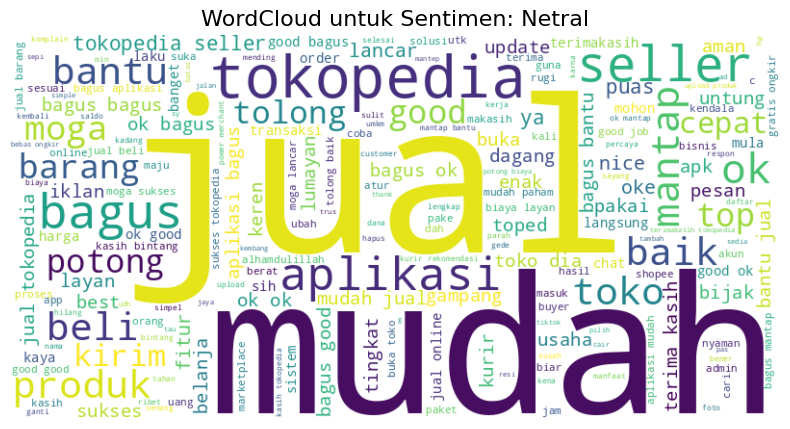

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_positif = ' '.join(df[df['sentimen'] == 'positif']['stemming'].dropna())
wordcloud_positif = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_positif)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positif, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud untuk Sentimen: Positif', fontsize=16)
plt.show()


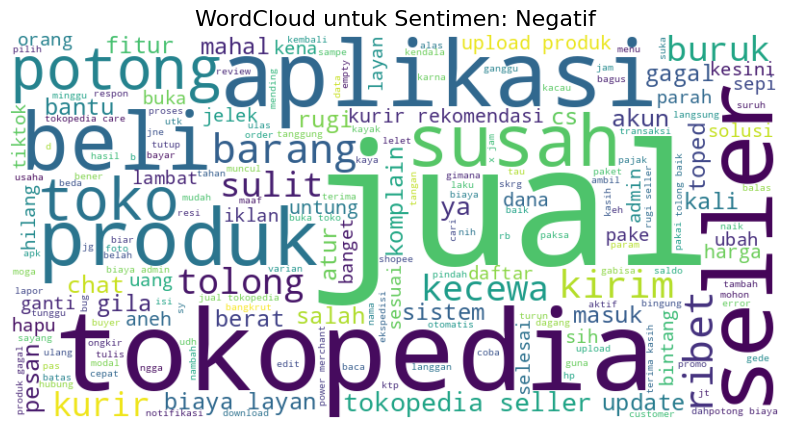

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_negatif = ' '.join(df[df['sentimen'] == 'negatif']['stemming'].dropna())
wordcloud_negatif = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_negatif)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negatif, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud untuk Sentimen: Negatif', fontsize=16)
plt.show()


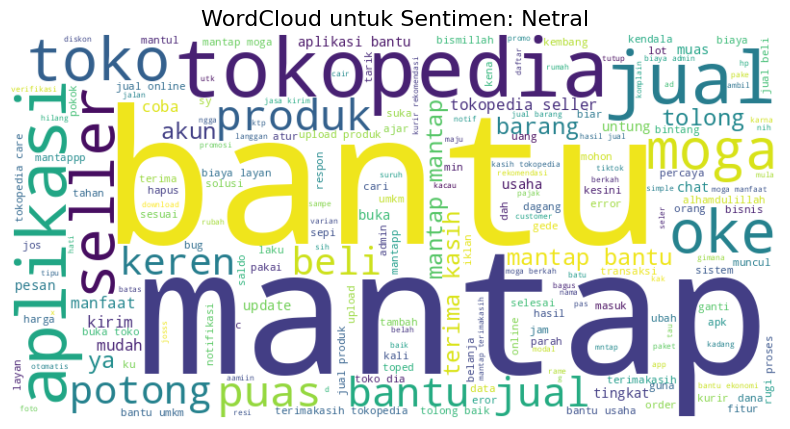

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_netral = ' '.join(df[df['sentimen'] == 'netral']['stemming'].dropna())
wordcloud_netral = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_netral)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_netral, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud untuk Sentimen: Netral', fontsize=16)
plt.show()


# **Model**

### **SKEMA 1**

RANDOM FOREST + TF_IDF (untuk rf)

tf_idf untuk rf yaitu sebagai input model dimana dalam tahapan ini kita mengubah dokumen teks menjadi matriks angka/numerik, tf_idf untuk rf ini menggunakan unigram, kemudian kata yang muncul di >85% akan diabaikan dan max_features yang diambil 1500

In [34]:
tfidf_rf = TfidfVectorizer(
    ngram_range=(1,1),
    max_df=0.85,
    min_df=5,
    max_features=1500,
    sublinear_tf=True
)

kemudian kita splitting datanyan 70% untuk daat pelatihan(train) dan 30% untuk pengujian(test)

In [35]:
X_tfidf_rf = tfidf_rf.fit_transform(df['stemming'])
X_train_rf, X_test_rf, y_train, y_test = train_test_split(
    X_tfidf_rf, df['sentimen'], test_size=0.3, random_state=42
)


**Model Random Forest dan Evaluasi Model**

In [36]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_rf, y_train)
y_pred_rf = model_rf.predict(X_test_rf)

print("Skema 1: Random Forest + TF-IDF")
print("Akurasi:", accuracy_score(y_test, y_pred_rf))
print("Laporan Klasifikasi:\n", classification_report(y_test, y_pred_rf))


Skema 1: Random Forest + TF-IDF
Akurasi: 0.8763636363636363
Laporan Klasifikasi:
               precision    recall  f1-score   support

     negatif       0.77      0.71      0.74       366
      netral       0.86      0.94      0.90      1526
     positif       0.93      0.85      0.89      1408

    accuracy                           0.88      3300
   macro avg       0.85      0.83      0.84      3300
weighted avg       0.88      0.88      0.88      3300



### **SKEMA 2**

SGDClassifier + TF-IDF

SGD = Stochastic Gradient Descent

pada algoritma ini kita juga menggunakan tf_idf yaitu mengubah teks menjadi representasi numerik dalam proyek ini kita juga menerapkan dalam tf_idf yaitu menangkap konteks dengan kata bigram, dan memfilter kata yang terlalu umum.

In [40]:
tfidf_sgd = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True,
    norm='l2',
    max_features=5000
)
X_tfidf_sgd = tfidf_sgd.fit_transform(df['stemming'])

split data latih dan data uji

In [50]:
X_train_sgd, X_test_sgd, y_train, y_test = train_test_split(
    X_tfidf_sgd, df['sentimen'], test_size=0.3, random_state=42
)

**Model SGDClassifier dan Evaluasi Model**

In [43]:
model_sgd = SGDClassifier(
    loss='hinge',
    penalty='l2',
    alpha=1e-4,
    random_state=42,
    max_iter=3000,
    tol=1e-3
)
model_sgd.fit(X_train_sgd, y_train)
y_pred_sgd = model_sgd.predict(X_test_sgd)

print("\nSkema 2: SGDClassifier  + TF-IDF ")
print("Akurasi:", accuracy_score(y_test, y_pred_sgd))
print("Laporan Klasifikasi:\n", classification_report(y_test, y_pred_sgd))



Skema 2: SGDClassifier  + TF-IDF 
Akurasi: 0.8542424242424242
Laporan Klasifikasi:
               precision    recall  f1-score   support

     negatif       0.77      0.69      0.73       366
      netral       0.84      0.92      0.88      1526
     positif       0.90      0.83      0.86      1408

    accuracy                           0.85      3300
   macro avg       0.83      0.81      0.82      3300
weighted avg       0.86      0.85      0.85      3300



### **SKEMA 3**

RANDOM FOREST + Bag of Words

pada skema 3 ini kita menggunakan CountVectorizer untuk mengubah teks menjadi frekuensi kemunculan kata

kita juga menggunakan unigram dan bigram (kata tunggal & dua kata berurutan)

kita mengatur max_feature 5000 kata atau frasa berdasarkan frekuensi teratas


In [45]:
vectorizer_bow = CountVectorizer(ngram_range=(1, 2), max_features=5000)
X_bow = vectorizer_bow.fit_transform(df['stemming'])

split data latih dan data uji

In [47]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    X_bow, df['sentimen'], test_size=0.3, random_state=42
)

**Model Random Forest dan Evaluasi Model**

In [51]:
model_rf_bow = RandomForestClassifier(n_estimators=200, random_state=42)
model_rf_bow.fit(X_train_bow, y_train)
y_pred_bow = model_rf_bow.predict(X_test_bow)


print("\nSkema 3: Random Forest + Bag of Words")
print("Akurasi:", accuracy_score(y_test, y_pred_bow))
print("Laporan Klasifikasi:\n", classification_report(y_test, y_pred_bow))



Skema 3: Random Forest + Bag of Words
Akurasi: 0.8575757575757575
Laporan Klasifikasi:
               precision    recall  f1-score   support

     negatif       0.78      0.64      0.70       366
      netral       0.81      0.97      0.88      1526
     positif       0.94      0.80      0.86      1408

    accuracy                           0.86      3300
   macro avg       0.85      0.80      0.82      3300
weighted avg       0.87      0.86      0.86      3300

